In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [3]:
cols = df.columns
numerical = []
categorical = []

In [4]:
for col in cols:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('NA')
        
        if col != 'converted':
            categorical.append(col)
    else:
        df[col] = df[col].fillna(0)
        
        if col != 'converted':
            numerical.append(col)

In [5]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [6]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [7]:
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [8]:
y_train = df_train['converted']
y_val = df_val['converted']
y_test = df_test['converted']

In [9]:
#Question 1

In [10]:
for col in numerical:
    auc = roc_auc_score(df_train['converted'], df_train[col])
    print(f"for col: {col},  auc is {auc}")

for col: number_of_courses_viewed,  auc is 0.7635680590007088
for col: annual_income,  auc is 0.5519578313253012
for col: interaction_count,  auc is 0.738270176293409
for col: lead_score,  auc is 0.6144993577250176


In [11]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [12]:
#Question 2

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer

In [14]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dicts)
X_train = dv.transform(train_dicts)

In [15]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [16]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
y_pred = model.predict_proba(X_val)[:,1]

In [18]:
round(roc_auc_score(y_val, y_pred), 3)

0.817

In [19]:
#Question 3

In [20]:
scores = []
thresholds = np.linspace(0, 1, 101)

In [21]:
for t in thresholds:
    features = categorical + numerical
    train_dicts = df_train[features].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dicts)
    X_train = dv.transform(train_dicts)
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    val_dicts = df_val[features].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    y_pred = model.predict_proba(X_val)[:,1]
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    scores.append((t, tp, tn, fp, fn))

In [22]:
columns = ['threshold', 'tp', 'tn', 'fp', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)


In [28]:
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

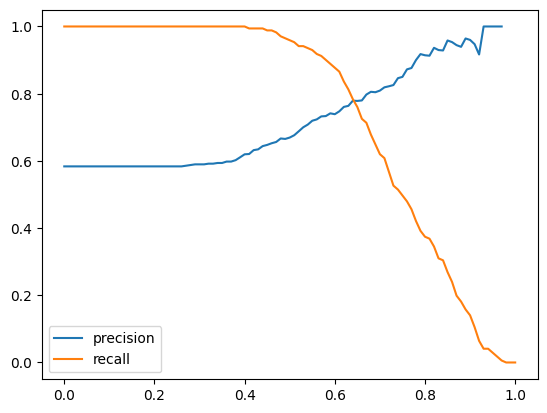

In [24]:
import matplotlib.pyplot as plt

plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

In [25]:
#Question 4

In [29]:
df_scores['F1'] = 2 * df_scores.precision * df_scores.recall / (df_scores.precision + df_scores.recall)
df_scores

,threshold,tp,tn,fp,fn,precision,recall,F1
0,0.00,171,0,122,0,0.583618,1.000000,0.737069
1,0.01,171,0,122,0,0.583618,1.000000,0.737069
2,0.02,171,0,122,0,0.583618,1.000000,0.737069
3,0.03,171,0,122,0,0.583618,1.000000,0.737069
4,0.04,171,0,122,0,0.583618,1.000000,0.737069
...,...,...,...,...,...,...,...,...
96,0.96,3,122,0,168,1.000000,0.017544,0.034483
97,0.97,1,122,0,170,1.000000,0.005848,0.011628
98,0.98,0,122,0,171,NaN,0.000000,NaN
99,0.99,0,122,0,171,NaN,0.000000,NaN


In [30]:
df_scores.sort_values(by='F1', ascending=False)

,threshold,tp,tn,fp,fn,precision,recall,F1
57,0.57,156,65,57,15,0.732394,0.912281,0.812500
55,0.55,159,60,62,12,0.719457,0.929825,0.811224
56,0.56,157,62,60,14,0.723502,0.918129,0.809278
59,0.59,152,69,53,19,0.741463,0.888889,0.808511
58,0.58,154,66,56,17,0.733333,0.900585,0.808399
...,...,...,...,...,...,...,...,...
96,0.96,3,122,0,168,1.000000,0.017544,0.034483
97,0.97,1,122,0,170,1.000000,0.005848,0.011628
98,0.98,0,122,0,171,NaN,0.000000,NaN
99,0.99,0,122,0,171,NaN,0.000000,NaN


In [31]:
#Question 5

In [41]:
def train(df_train, y_train, C):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
 
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
 
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
 
    return dv, model

In [42]:
def predict(df, dv, model):
     dicts = df[categorical + numerical].to_dict(orient='records')
 
     X = dv.fit_transform(dicts)
     y_pred = model.predict_proba(X)[:,1]
 
     return y_pred

In [43]:
from sklearn.model_selection import KFold
 
kfold = KFold(n_splits=5, shuffle=True, random_state=1)  
scores = []
 
for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
 
    y_train = df_train.converted.values
    y_val = df_val.converted.values
 
    dv, model = train(df_train, y_train, 1)
    y_pred = predict(df_val, dv, model)
 
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

In [44]:
np.std(scores)

np.float64(0.03580711942905165)

In [40]:
#Question 6

In [48]:
n_splits = 5
 
for C in [0.000001, 0.001, 1]:
    scores = []
 
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)  
 
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
 
        y_train = df_train.converted.values
        y_val = df_val.converted.values
 
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
 
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
 
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
